## Wprowadzenie

Pomimo ogromnych sukcesów, jakie metody uczenia głębokiego odniosły w ciągu ostatnich kilkunastu lat
w dziedzinach takich jak widzenie maszynowe i przetwarzanie języka naturalnego, ich przewaga nad
klasycznymi algorytmami w uczeniu na danych tabelarycznych — prawdopodobnie najpowszechniejszym
typie danych — wciąż nie jest oczywista. Co więcej, patrząc na metody najczęściej stosowane w
praktyce oraz modele osiągające najlepsze wyniki w konkursach, np. na platformie Kaggle, można wręcz
wysnuć przeciwny wniosek: to klasyczne metody, takie jak lasy losowe czy Gradient Boosted Decision
Trees (GBDT), okazują się bardziej efektywne niż modele neuronowe w przypadku danych tabelarycznych.

W artykule Grinsztajna i in. [1] przedstawiono wyniki eksperymentalne, które zdają się potwierdzać
przewagę modeli klasycznych opartych na drzewach decyzyjnych nad prostymi sieciami neuronowymi.
Autorzy przeprowadzili obszerne eksperymenty na kolekcji 45 różnych tabelarycznych zbiorów danych,
które są według nich reprezentatywne dla tych typowo spotykanych. Wśród tej kolekcji wyróżnili oni
następujące 4 klasy: zagadnienia klasyfikacji na cechach numerycznych, zagadnienia klasyfikacji na
cechach mieszanych, zagadnienia regresji na cechach numerycznych oraz zagadnienia regresji na
cechach mieszanych. Dla tych czterech klas porównali oni efektywność modeli drzewiastych (XGBoost,
RandomForest, GradientBoostingTree oraz HistGradientBoostingTree z biblioteki Scikit-learn) i modeli
neuronowych (MLP, Resnet, FTTransformer, SAINT) w zależności od liczby kroków losowego
przeszukiwania siatek hiperparametrów odpowiednich modeli. W szczególności dla problemów
klasyfikacji na cechach numerycznych otrzymali następujące wyniki.

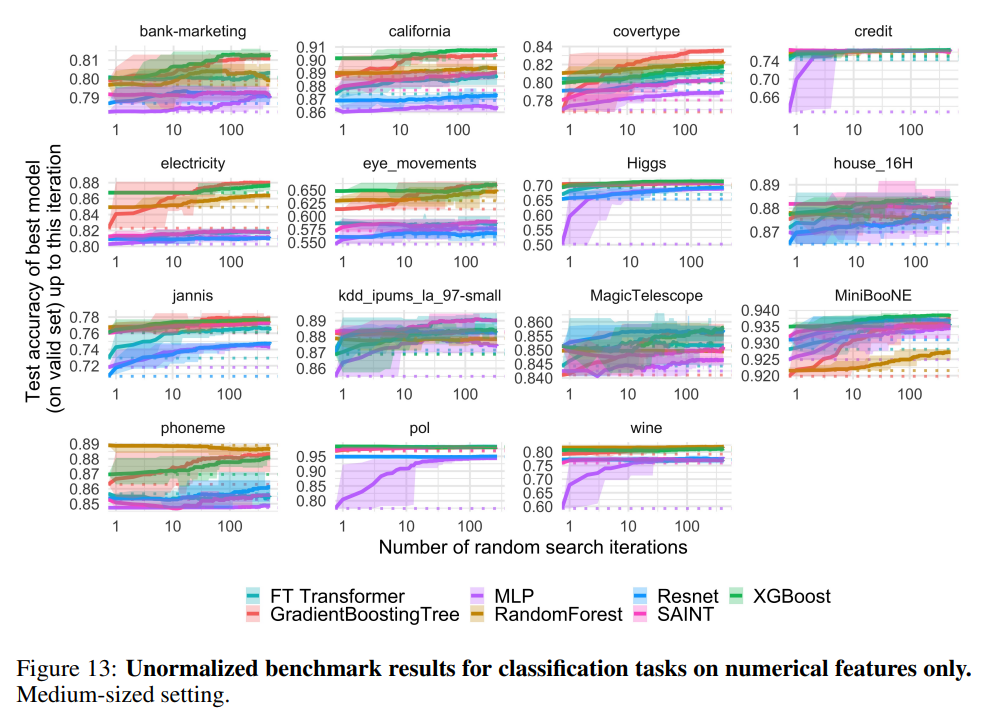

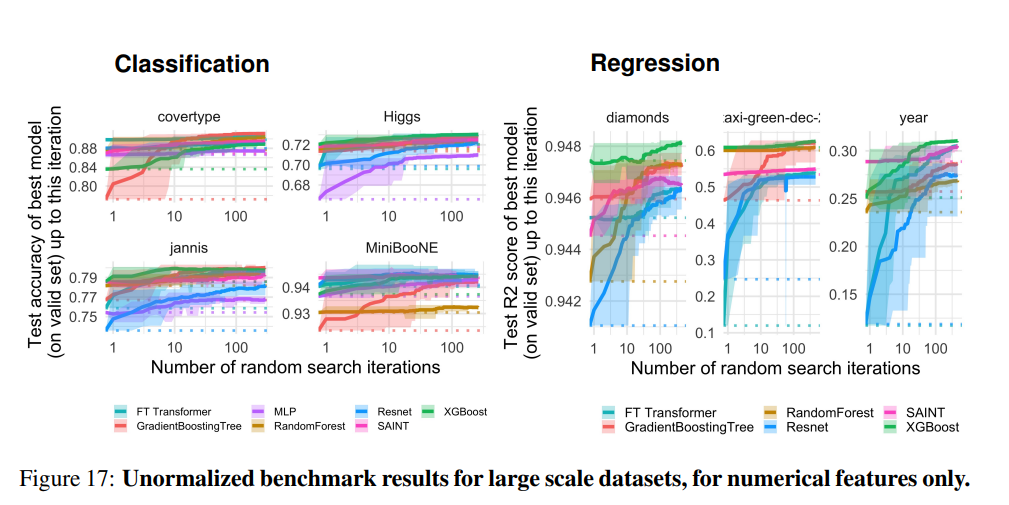

Z przedstawionych danych wynika, że domyślna sieć MLP charakteryzuje się bardzo słabą skutecznością.
Co więcej, ze względu na czasochłonny proces treningu, optymalizacja hiperparametrów (HPO) nie
rozwiązuje tego problemu w sposób efektywny.

W cytowanym artykule znajduje się również analiza własności modeli głębokich, które mogą stanowić
wyjaśnienie ich niskiej efektywności na danych tabelarycznych. Autorzy stawiają tezę, iż niska
skuteczność sieci neuronowych wynika z następujących własności:

1. Sieci neuronowe preferują gładkie granice decyzyjne (*smoothness bias*);

2. Nieistotne cechy mają większy wpływ na sieci MLP niż na inne modele (*effect of uninformative
   features*), a dane tabelaryczne często zawierają wiele takich predyktorów;

3. Standardowe sieci MLP uczone stochastycznym spadkiem wzdłuż gradientu (SGD) są niemiennicze
   względem obrotów -- w sensie udowodnionym przez Ng [3];

co opierają na doświadczalnej analizie zmian skuteczności modeli przy konkretnych transformacjach
zbiorów treningowych (usunięciu nieistotnych predyktorów oraz wygładzeniu zmiennej objaśnianej w
zbiorze treningowym za pomocą wygładzania gaussowskiego).

Autorzy wspominają również, że ich obserwacje mogą tłumaczyć poprawę skuteczności prostych sieci MLP
na danych tabelarycznych, jaką zaobserwowano w pracy Gorishniy’ego i in. [2], gdy do architektury
dodano warstwę enkodującą (*encoding*) lub osadzającą (*embedding*). W szczególności jedna z
zaproponowanych warstw enkodujących opiera się na dyskretyzacji zmiennych numerycznych, co --
zgodnie z zamieszconymi w artykule wynikami eksperymentalnymi -- zdaje się wyraźnie poprawia
skuteczność modeli neuronowych.

Ponieważ celem niniejszych eksperymentów jest właśnie analiza wpływu dyskretyzacji na skuteczność
sieci neuronowych, jako punkt wyjścia omówimy i przeanalizujemy uzyskane w pracy [2] wyniki.

### Piecewise Linear Encoding (PLE)

W pracy [2] autorzy proponują następujący sposób kodowania zmniennej numerycznej $x \in
\mathbb{R}^d$ w postaci wektora $\mathbf{z} \in \mathbb{R}^T$. Najpierw dzielimy zakres wartości
zmiennej numeryczej na $T$ przedziałów $B_1,\ldots,B_T$ (ang. *bins*) postaci $B_t = [b_{t-1},
b_{t})$. Następnie definiujemy odwzorowanie $\text{PLE}: \mathbb{R} \ni x \mapsto \mathbf{z} \in
\mathbb{R}^T$
$$
    \text{PLE}(x) = (e_1,\ldots,e_T)\,,\quad e_t = \begin{cases} 0 &\quad x < b_{t-1}, t > 1\\ 
                                                                 1 &\quad x\geq b_t, t < T\\
                                                                 \frac{x-b_{t-1}}{b_t - b_{t-1}} &\quad\text{otherwise}
                                                    \end{cases}
$$
które określa nasze kodowanie.

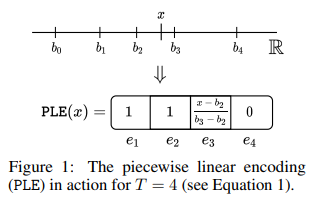

Podział na przedziały można wykonać prostą metodą kwantylową, w której krańce $b_t$ są wyznaczane na
podstawie empirycznych kwantyli.


Bibliografia:

[1] Léo Grinsztajn, Edouard Oyallon, & Gaël Varoquaux. (2022). Why do tree-based models still
    outperform deep learning on tabular data?. https://arxiv.org/pdf/2207.08815

[2] Yury Gorishniy, Ivan Rubachev, & Artem Babenko. (2023). On Embeddings for Numerical Features in
    Tabular Deep Learning. https://arxiv.org/pdf/2203.05556

[3] Andrew Y. Ng. (2004). Feature selection, L1 vs. L2 regularization, and rotational invariance.
    https://icml.cc/Conferences/2004/proceedings/papers/354.pdf

## Eksperymenty

### Modele i zbiory danych

### Experiment design

### Hardware

In [1]:
import time
import pickle
import logging

import numpy as np
import pandas as pd

from warnings import simplefilter
from collections import defaultdict

from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer, KBinsDiscretizer

from mlp import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

In [2]:
datasets = {
    "electricity": 44120,
    "covertype": 44121,
    "pol": 44122,
    "house_16H": 44123,
    "kdd": 44124,
    "MagicTelescope": 44125,
    "bank_marketing": 44126,
    "phoneme": 44127,
    "miniboone": 44128,
    "higgs": 44129,
    "eye_movements": 44130,
    "jannis": 44131,
    "credit": 44089,
    "california": 44090,
    "wine": 44091,
}

In [ ]:
logger = logging.getLogger()
logging.basicConfig(
    filename=f"logs/experiment_{time.strftime('%Y%m%d-%H%M%S')}.log",
    format="%(asctime)s:%(levelname)s:%(message)s",
    encoding="utf-8",
    filemode="w",
    force=True,
    level=logging.DEBUG,
)
simplefilter("ignore", UserWarning)

random_state = 0
results = defaultdict(list)

for dataset, data_id in datasets.items():
    X: pd.DataFrame
    y: pd.DataFrame
    X, y = fetch_openml(data_id=data_id, return_X_y=True, as_frame=True)

    logger.info(f"{dataset=} | size = {X.shape} | #NaN = {X.isna().sum().sum()}\n" + "=" * 100)

    skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    for fold_idx, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        logger.info(f"Fold {fold_idx}:\n" + "-" * 100)

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if len(X_train) > 50_000:
            batch_size = 1024
        else:
            batch_size = 256

        clfs = {
            "LogisticRegression": make_pipeline(
                QuantileTransformer(output_distribution="normal", random_state=random_state),
                LogisticRegression(max_iter=1_000, random_state=random_state),
            ),
            "RandomForestClassifier": RandomForestClassifier(random_state=random_state),
            "HistGradientBoostingClassifier": HistGradientBoostingClassifier(random_state=random_state),
            "MLPWithRawFeatures": make_pipeline(
                QuantileTransformer(output_distribution="normal", random_state=random_state),
                MLPClassifier(batch_size=batch_size, use_quantile_encoding=False, random_state=random_state),
            ),
            "MLPWithQuantilePLEEncoding": MLPClassifier(
                batch_size=batch_size, use_quantile_encoding=True, random_state=random_state
            ),
            "MLPWithQuantileOrdinalEncoding": make_pipeline(
                KBinsDiscretizer(n_bins=48, encode="ordinal", strategy="quantile", random_state=random_state),
                MLPClassifier(batch_size=batch_size, use_quantile_encoding=False, random_state=random_state),
            ),
        }

        try:
            for clf_name, clf in clfs.items():
                t = time.perf_counter()
                clf.fit(X_train, y_train)
                t = time.perf_counter() - t
                acc = accuracy_score(y_test, clf.predict(X_test))

                results[dataset, clf_name, "fit_times"].append(t)
                results[dataset, clf_name, "test_acc_scores"].append(acc)

                logger.info(f"{clf_name:>30s} | TEST ACC. {acc:.2%} | FIT TIME {t:.3f}s")

            fname = f"results/checkpoints/{time.strftime('%Y%m%d-%H%M%S')}_{dataset}_{fold_idx}.pickle"
            with open(fname, "wb") as file:
                pickle.dump(results, file, protocol=pickle.HIGHEST_PROTOCOL)

        except Exception as e:
            logger.error(f"Exception at {dataset=}, {fold_idx=}: {e}")

logger.handlers.clear()

with open(f"results/results_{time.strftime('%Y%m%d-%H%M%S')}.pickle", "wb") as file:
    pickle.dump(results, file, protocol=pickle.HIGHEST_PROTOCOL)

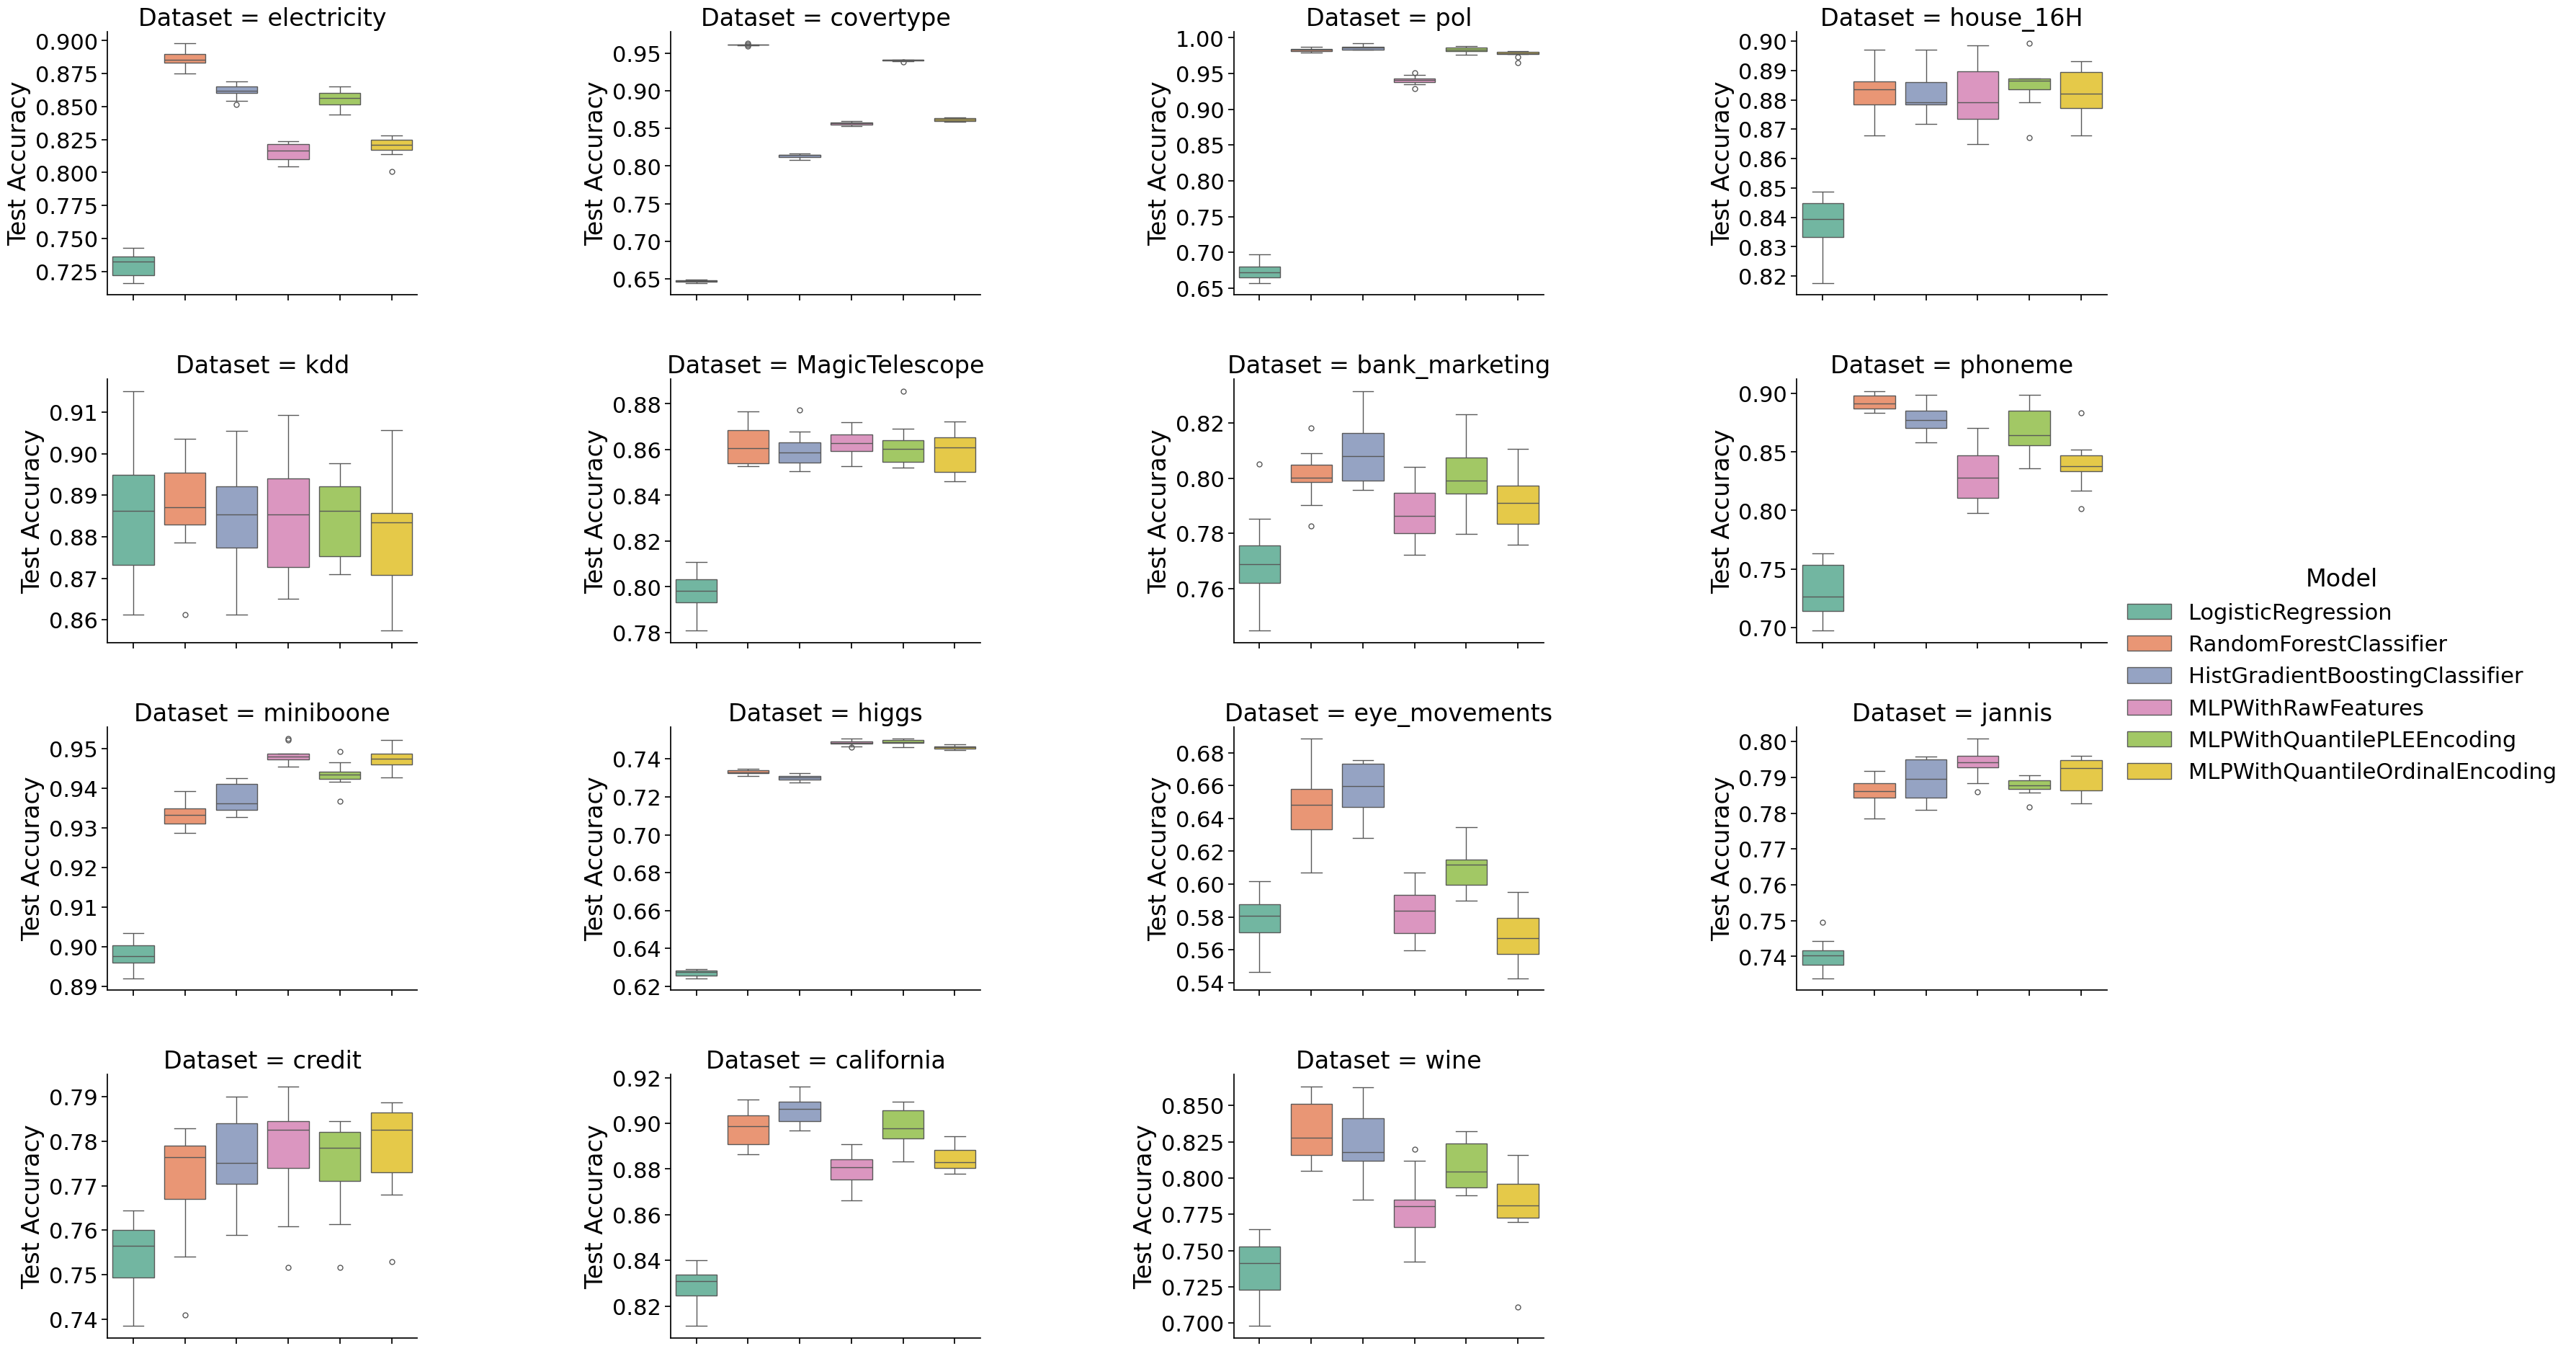

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

results_path = "results/results_20250506-082815.pickle"
with open(results_path, "rb") as file:
    df = pd.DataFrame(pickle.load(file))

df_melt = df.xs(key="test_acc_scores", axis=1, level=2).melt()
df_melt.columns = ["Dataset", "Model", "Accuracy"]

with sns.plotting_context("notebook", font_scale=2):
    fg = sns.catplot(
        data=df_melt,
        x="Model",
        y="Accuracy",
        hue="Model",
        col="Dataset",
        kind="box",
        legend="full",
        legend_out=True,
        col_wrap=4,
        sharey=False,
        palette="Set2",
        aspect=1.5,
    )

    for ax in fg.axes.flatten():
        ax.set_xticklabels([])
        ax.set_xlabel("")
        ax.set_ylabel("Test Accuracy")

In [4]:
from millify import millify

df_acc = df.xs(key="test_acc_scores", axis=1, level=2)
models = df_acc.columns.get_level_values(1).unique()

df_acc_agg = pd.DataFrame()
df_acc_agg["acc_avg"] = df_acc.mean()
df_acc_agg["acc_std"] = df_acc.std()

for dataset, data_id in datasets.items():
    size = len(fetch_openml(data_id=data_id, return_X_y=True, as_frame=True)[0])
    for model in models:
        df_acc_agg.loc[(dataset, models), "size"] = size

df_acc_agg = df_acc_agg.reset_index()
df_acc_agg.columns = ["Dataset", "Model", "Accuracy mean", "Accuracy std.", "Size"]
df_acc_agg.loc[:, "log(Size)"] = np.log(df_acc_agg.loc[:, "Size"])

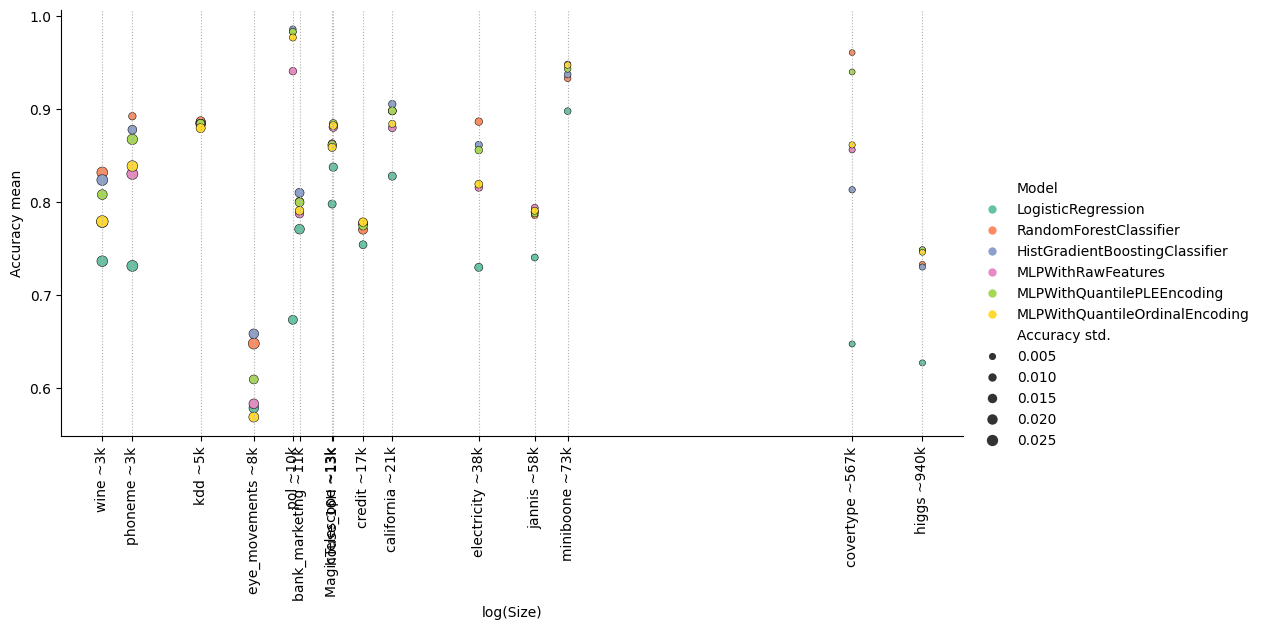

In [5]:
fg = sns.relplot(
    data=df_acc_agg,
    y="Accuracy mean",
    x="log(Size)",
    hue="Model",
    size="Accuracy std.",
    palette="Set2",
    edgecolors="k",
    aspect=2,
)
df_acc_agg_sort = df_acc_agg.sort_values(by="log(Size)")
fg.ax.set_xticks(
    ticks=df_acc_agg_sort.loc[:, "log(Size)"].unique(),
    labels=pd.unique(df_acc_agg_sort.loc[:, "Dataset"] + " ~" + df_acc_agg_sort.loc[:, "Size"].apply(millify)),
    rotation=90,
)
fg.ax.grid(True, which="major", axis="x", ls="dotted", lw=0.8)

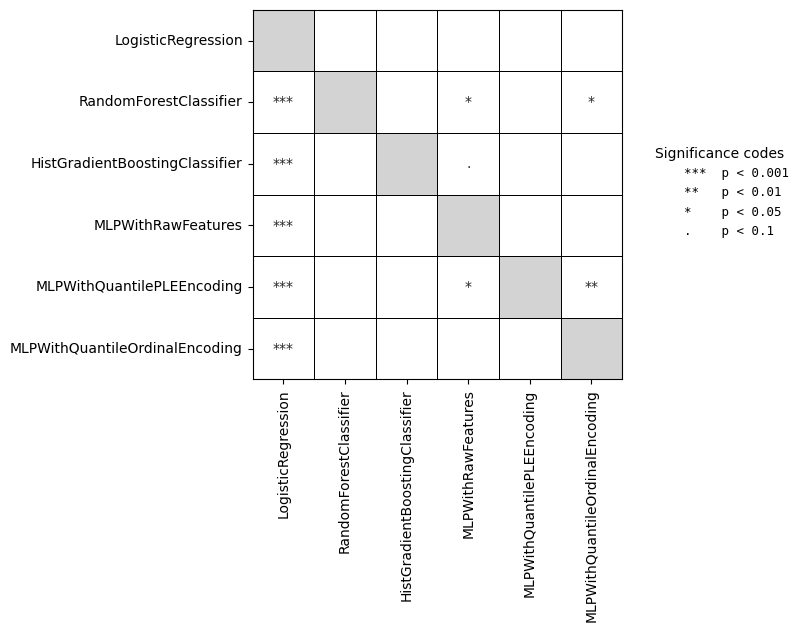

In [ ]:
from scipy import stats
from itertools import product
from matplotlib.patches import Patch


def significance_codes(p: float):
    if p < 0.001:
        return "***"
    if p < 0.01:
        return "**"
    if p < 0.05:
        return "*"
    if p < 0.1:
        return "."
    return ""


df_acc = df.xs(key="test_acc_scores", axis=1, level=2)
models = df_acc.columns.get_level_values(1).unique()

pvalue_matrix = pd.DataFrame(float("nan"), index=models, columns=models)
for m1, m2 in product(models, repeat=2):
    if m1 == m2:
        continue
    pvalue_matrix.loc[m1, m2] = stats.wilcoxon(
        df_acc.mean().xs(key=m1, level=1),
        df_acc.mean().xs(key=m2, level=1),
        alternative="greater",
    ).pvalue

fig, ax = plt.subplots()
sns.heatmap(
    pvalue_matrix.isna(),
    cmap=["white", "lightgrey"],
    fmt="",
    annot=pvalue_matrix.map(significance_codes),
    linewidths=0.4,
    linecolor="k",
    cbar=False,
    square=True,
    ax=ax,
)

for _, spine in ax.spines.items():
    spine.set_visible(True)

fig.legend(
    handles=[
        Patch(facecolor="w", edgecolor="w", label="***  p < 0.001"),
        Patch(facecolor="w", edgecolor="w", label="**   p < 0.01"),
        Patch(facecolor="w", edgecolor="w", label="*    p < 0.05"),
        Patch(facecolor="w", edgecolor="w", label=".    p < 0.1"),
    ],
    title="Significance codes",
    loc="center right",
    bbox_to_anchor=(1.08, 0.5),
    frameon=False,
    prop={"family": "monospace", "size": 9},
)
pass